# Попиксельное преобразование изображений
# 每像素图像转换

В этом блокноте мы рассмотрим простой пример попиксельных изменений (преобразований) изображений.  
在本笔记本中，我们将查看图像逐像素更改（转换）的简单示例。

Для начала установим необходимую версию библиотеки и подключим то, чем будем пользоваться в дальнейшем.  
首先，让我们安装所需版本的库并连接我们将来要使用的库。

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

Считаем исходное изображение и переведем его из цветового пространства BGR в привычное RGB. Представление картинки — тензор. В элементе <code>img_original[i][j]</code> содержится $3$ значения, равные интенсивностям пикселя $(i, j)$ относительно трех цветовых каналов; значения находятся в диапазоне $[0, 255] \cap \mathbb Z$.  
我们读取原始图像并将其从 BGR 颜色空间转换为通常的 RGB。图片的表示是张量。 <code>img_original[i][j]</code> 元素包含 $3$ 值，等于相对于三个颜色通道的像素强度 $(i, j)$；值的范围为 $[0, 255] \cap \mathbb Z$。

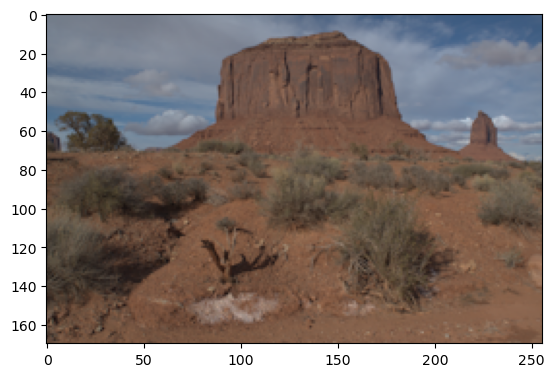

In [2]:
img_original = cv2.imread('a0001-jmac_DSC1459.dng')
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original)
plt.show()

Найдем ширину, высоту и среднее значение интенсивности пикселя исходного изображения:  
让我们找到原始图像的宽度、高度和平均像素强度：

In [3]:
print("высота:", img_original.shape[0], "ширина:", img_original.shape[1])
print("среднее значение интенсивности пикселя:", np.mean(img_original))

высота: 170 ширина: 256
среднее значение интенсивности пикселя: 97.55773590686275


## Изменение экспозиции вручную  
## 手动更改曝光

Применим к каждому пикселю преобразование, задаваемое следующим образом: $I(out) = I(in) \cdot 2^p$, где $p$ - некоторый параметр из $[-1,1]$. Пусть, скажем, $p = 0.8$.  
让我们对每个像素应用如下指定的变换：$I(out) = I(in) \cdot 2^p$，其中$p$ 是来自$[-1,1]$ 的某个参数。假设 $p = 0.8$。

In [4]:
def exposure(image, p):
    return image.copy() * (2 ** p)

img_result = exposure(img_original, 0.8)


Посмотрим на новое изображение  
让我们看看新图像

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


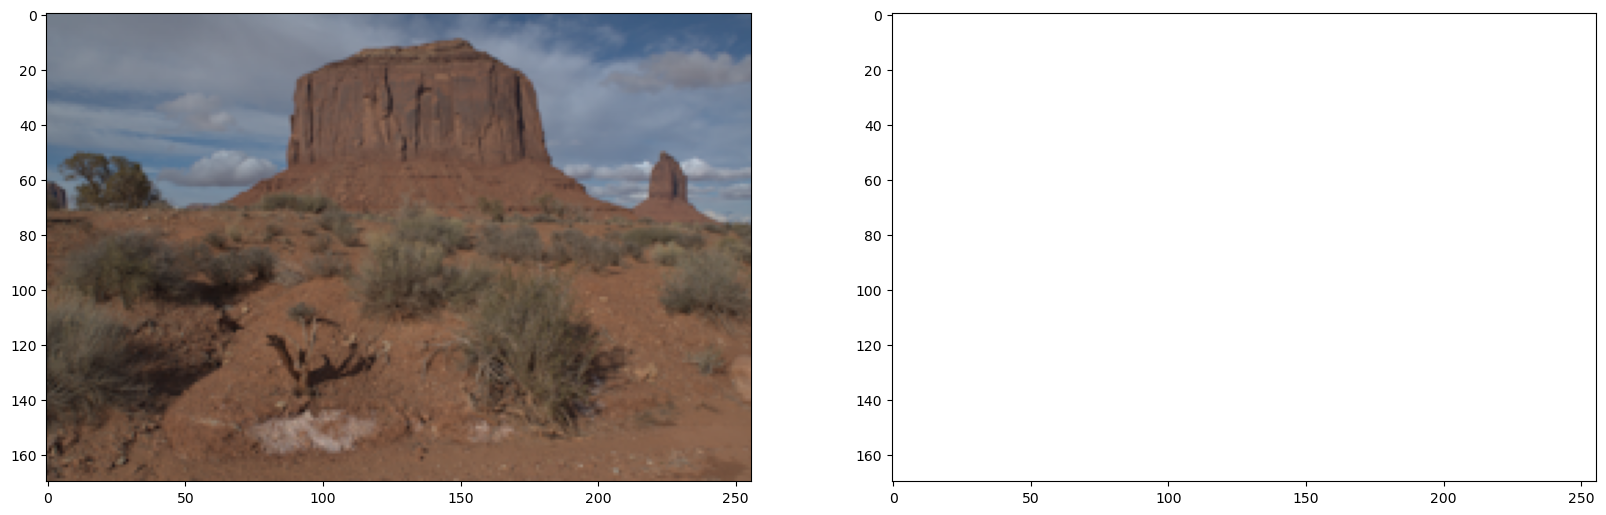

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Новое изображение нам не увидеть. Разберемся, в чем причина. Дело в том, что рассматриваемое преобразование, по своей сути, просто изменяет значение интенсивности каждого пикселя в $2^p$ раз. Очевидно, что, во-первых, могут быть получены значения большие, чем 255, во-вторых, значения скорее всего не будут целыми:  
我们将无法看到新图像。我们来看看到底是什么原因。事实上，所讨论的变换本质上只是将每个像素的强度值改变 $2^p$ 倍。显然，首先，可以获得大于255的值，其次，这些值很可能不是整数：

In [6]:
img_result[50][50]

array([200.22662956, 231.56644984, 268.1295735 ])

Если мы попытаемся избавиться только от первой проблемы, то изображение мы получим, но совсем не то, которое хотели:  
如果我们尝试只解决第一个问题，那么我们将得到一个图像，但根本不是我们想要的图像：

In [7]:
def exposure(image, p):
    img_result = image.copy()
    for i in range(0, img_result.shape[0]):
      for j in range(0, img_result.shape[1]):
        img_result[i,j] = (round(img_result[i,j][0]*2**p,0),round(img_result[i,j][1]*2**p,0),round(img_result[i,j][2]*2**p,0))
    return img_result

img_result = exposure(img_original, 0.8)

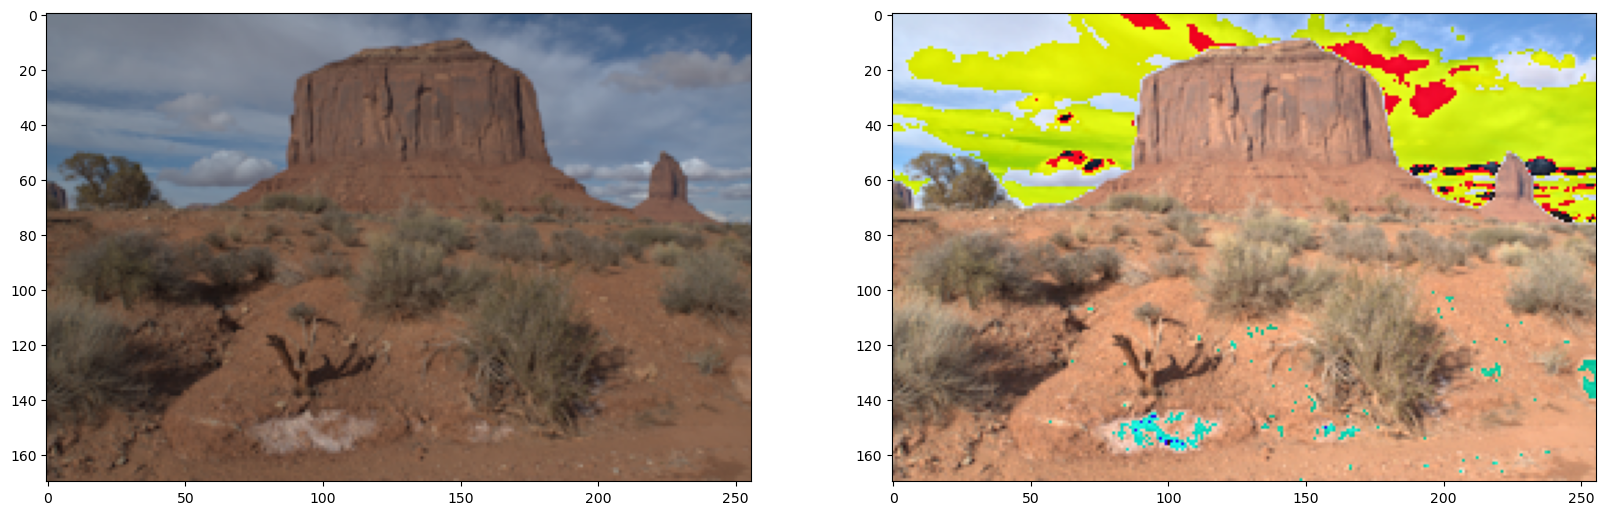

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Изображение в этом конкретном случае хоть и стало стетлее, но с цветом тут явно что-то не то. Дело заключается в способе хранения самого изображения. Из-за того, что для хранения значения интенсивности отведено $8$ бит, при превышении значения в $255$ происходит циклический сдвиг (берется остаток по $\mod 256$). Например, пиксель
<code>img_result[50][50]</code> имеет следующие значения интенсивностей (после округления):  
虽然本例中的图像变得更加清晰，但颜色显然有问题。问题在于图像本身的存储方式。由于分配了$8$位来存储强度值，当超过$255$的值时，会发生循环移位（余数取$\mod 256）$。例如，像素 <code>img_result[50][50]</code> 具有以下强度值（四舍五入后）：

$$
[200, 232, 268],
$$
но из-за циклического сдвига результат другой ($268 \mod 256 = 12$):  
但由于循环移位，结果不同（$268 \mod 256 = 12$）：

In [9]:
img_result[50][50]

array([200, 232,  12], dtype=uint8)

Логичным кажется следующее решение. Нецелые значения будем округлять, а значения, превосходящие 255, будем считать равными 255. Проверим, что это нам даст.  
以下解决方案似乎合乎逻辑。我们将对非整数值进行四舍五入，超过 255 的值将被视为等于 255。让我们检查一下这给我们带来了什么。

In [10]:
def exposure(image, p):
    img_result = np.round(image.copy() * (2 ** p),0)
    img_result = img_result.astype(int)
    for i in range(img_result.shape[0]):
      for j in range(img_result.shape[1]):
        for k in range(img_result.shape[2]):
          if img_result[i][j][k] > 255:
            img_result[i][j][k] = 255
    return img_result


img_result = exposure(img_original, 0.8)


In [11]:
img_result[50][50]

array([200, 232, 255])

Построим изображение  
让我们构建一个图像

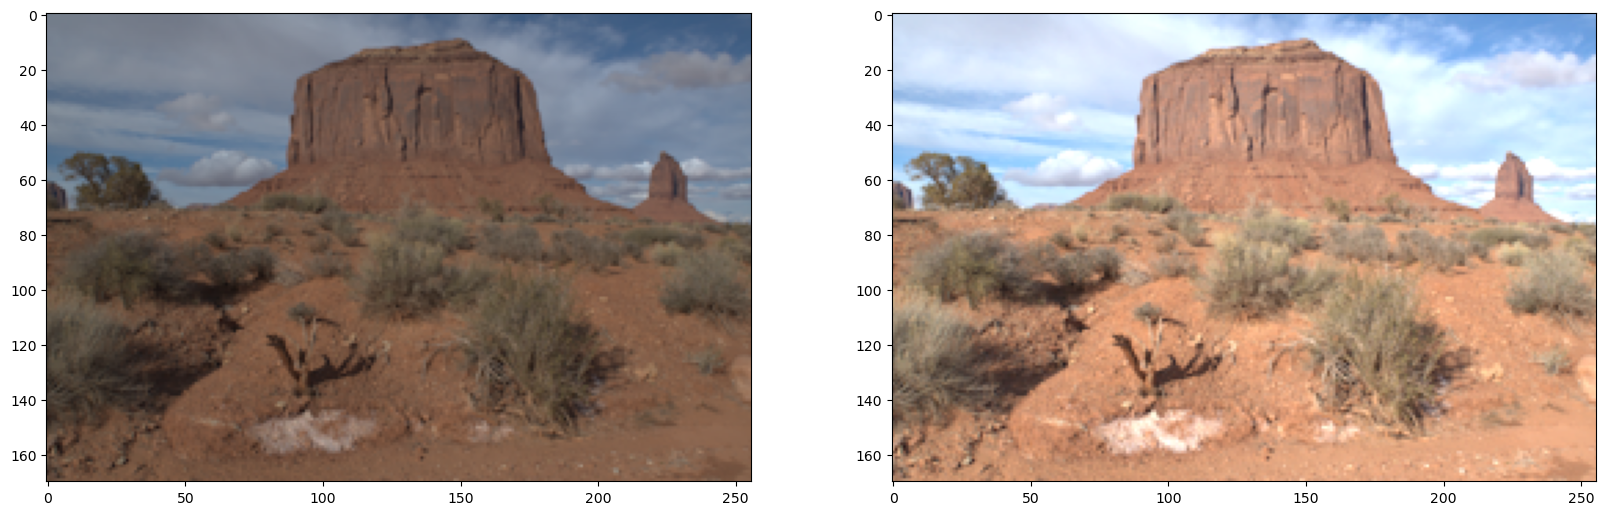

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result)

Cравним средние значения интенсивности пикселя для исходного и модифицированного изображений:

In [13]:
print("Среднее значение интенсивности пикселя исходного изображения:", np.mean(img_original))
print("Среднее значение интенсивности пикселя модифицированного изображения:", np.mean(img_result))

Среднее значение интенсивности пикселя исходного изображения: 97.55773590686275
Среднее значение интенсивности пикселя модифицированного изображения: 168.64738051470587


Для большей наглядности сравним гистограммы исходного и измененного изображений:  
为了更清楚起见，让我们比较原始图像和修改后图像的直方图：

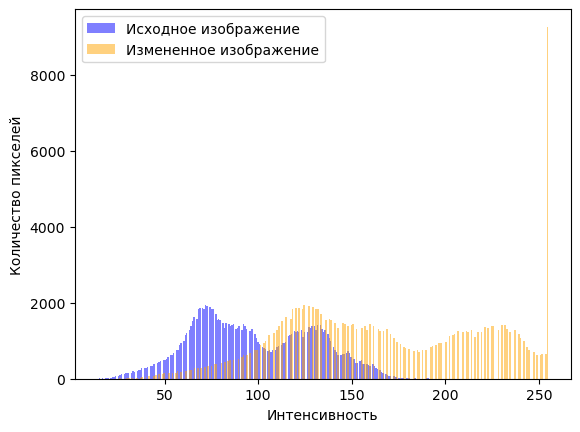

In [14]:
plt.hist(img_original.ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.hist(img_result.ravel(), bins = 256, color = 'Orange', alpha = 0.5)
plt.legend(['Исходное изображение', 'Измененное изображение'])
plt.xlabel('Интенсивность')
plt.ylabel('Количество пикселей')
plt.show()

Измененное изображение сместилось вправо (в более светлую область), чего и следовало ожидать. При этом достаточно большое количество пикселей имеет значение, равное 255.  
修改后的图像已向右移动（进入较亮的区域），这正是您所期望的。在本例中，相当多的像素值为 255。

Самостоятельно предлагается посмотреть понижение яркости, где соответсвующая гистограмма сместится влево.  
我们鼓励您独立观察亮度的下降，相应的直方图将向左移动。

# Изменение экспозиции при помощи библиотеки  
# 使用库更改曝光

Попробуем повторить произведенные преобразования средствами библиотеки CV2. Для этого нам потребуется сохранить изображение в файл, а затем произвести чтение из файла. При этом файл должен быть сжат алгоритмом без потери качества (например, подойдет .png; при использовании, например, .jpeg, результат будет немного другим).  
让我们尝试重复使用 CV2 库进行的转换。为此，我们需要将图像保存到文件中，然后从文件中读取。在这种情况下，必须使用不损失质量的算法来压缩文件（例如，.png 是合适的；例如，当使用 .jpeg 时，结果会略有不同）。

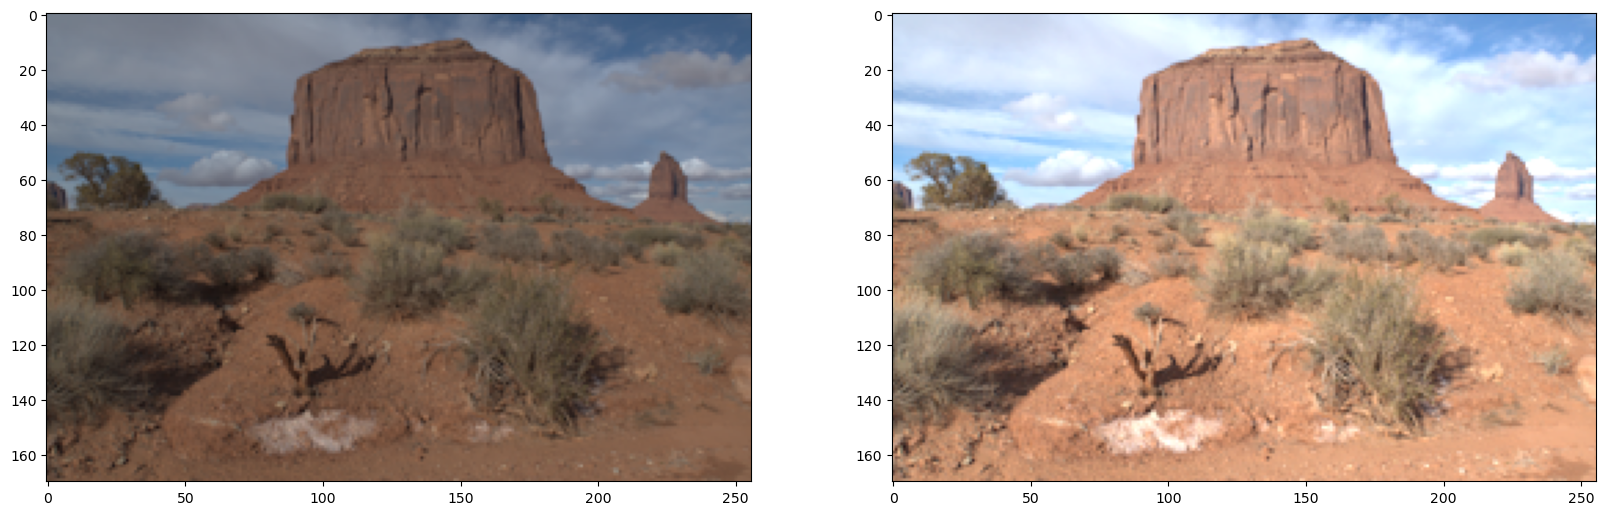

In [15]:
def exposure(image, p):
    return image.copy() * (2 ** p)

#Преобразование
img_result_lib = exposure(img_original, 0.8)
#Сохранение в файл
cv2.imwrite("img_result_lib.png", img_result_lib)
#Чтение из файла
img_result_lib = cv2.imread("img_result_lib.png")


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img_original)
axes[1].imshow(img_result_lib)

In [16]:
print("Среднее значение интенсивности пикселя изображения, измененного вручную:", np.mean(img_result))
print("Среднее значение интенсивности пикселя изображения, измененного библиотекой:", np.mean(img_result_lib))

Среднее значение интенсивности пикселя изображения, измененного вручную: 168.64738051470587
Среднее значение интенсивности пикселя изображения, измененного библиотекой: 168.64738051470587


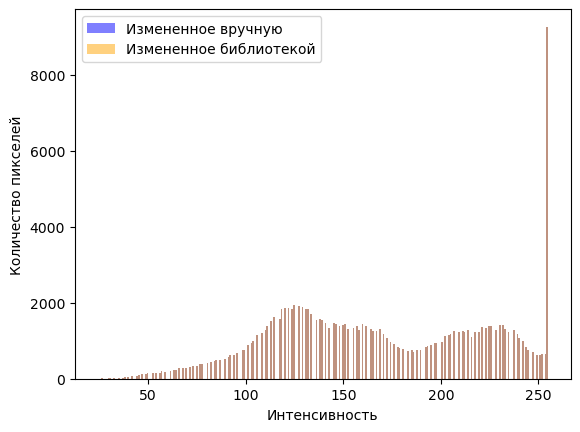

In [17]:
plt.hist(img_result_lib.ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.hist(img_result.ravel(), bins = 256, color = 'Orange', alpha = 0.5)
plt.legend(['Измененное вручную', 'Измененное библиотекой'])
plt.xlabel('Интенсивность')
plt.ylabel('Количество пикселей')
plt.show()

In [18]:
flag = True
for i in range(img_result.shape[0]):
      for j in range(img_result.shape[1]):
        for k in range(img_result.shape[2]):
          if (img_result[i][j][k] != img_result_lib[i][j][k]):
            flag = False
if flag == True:
  print('Результаты полностью совпали!')
else:
  print('Результаты не совпали!')

Результаты полностью совпали!
